BLOG
https://caelonsmith.medium.com/5-steps-to-improve-life-satisfaction-b060861038c3


In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
;

In [54]:
# Imports to bring data in
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [5]:
uploaded = files.upload()

Saving Wellbeing_and_lifestyle_data_Kaggle 2.csv to Wellbeing_and_lifestyle_data_Kaggle 2.csv


In [56]:
# create function to classify life satisfaction scores into 4 buckets 
def classifier(row):
  if row['WORK_LIFE_BALANCE_SCORE'] < 550:
    return 'Poor Score'
  elif row['WORK_LIFE_BALANCE_SCORE'] < 680:
    return 'Average Score'
  elif row['WORK_LIFE_BALANCE_SCORE'] < 700:
    return 'Good Score'
  else:
    return 'Excellent Score'

# wrangle function
def wrangle(filepath):
  df = pd.read_csv(io.BytesIO(uploaded[filepath]))

  # Set time column to datetime format
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)
  
  # Set index as the timestamp column
  df.set_index('Timestamp', inplace=True)
  
  # Clean daily stress data and set as int vs object
  df['DAILY_STRESS'].replace('1/1/00', '1', inplace=True)
  df['DAILY_STRESS'] = df['DAILY_STRESS'].astype(int)
  
  # Encode Gender to be 1 for male and 0 for female
  df["GENDER"] = np.where(df["GENDER"].str.contains("Male"), 1, 0)
  
  # CLASSIFY target column
  df['TARGET_CLASSIFICATION'] = df.apply(classifier, axis=1)

  # Drop bmi and income to distill better insights [TOGGLE AREA: COMMENT OUT THE DROP FUNCTION AND RUN ALL CELLS TO VIEW RESULTS WITH THESE COLUMNS INCLUDED]
  # df = df.drop(columns=['BMI_RANGE', 'SUFFICIENT_INCOME'])

  return df

In [57]:
filepath = 'Wellbeing_and_lifestyle_data_Kaggle 2.csv'
df = wrangle(filepath)

# Create dataframe for the regression analysis
# drop the classification target column
df_regression = df.drop(columns='TARGET_CLASSIFICATION')

# Use 90% of data for training and validation
df_train_regression = df_regression.tail((15972 - 1597))

# Use 10% of data for testing after training and validating
df_test_regression = df_regression.head(1597)
regression_X_test = df_test_regression.drop(columns='WORK_LIFE_BALANCE_SCORE')
regression_y_test = df_test_regression['WORK_LIFE_BALANCE_SCORE']

# Repeat above steps but for the classification analysis 
df_classification = df.drop(columns='WORK_LIFE_BALANCE_SCORE')
df_train_classification = df_classification.tail((15972 - 1597))
df_test_classification = df_classification.head(1597)
class_X_test = df_test_classification.drop(columns='TARGET_CLASSIFICATION')
class_y_test = df_test_classification['TARGET_CLASSIFICATION']

# Confirm dimensions and view head
print(df_train_regression.shape, df_test_regression.shape, df_train_classification.shape, df_test_classification.shape)
df_train_regression.head()

(14375, 23) (1597, 23) (14375, 23) (1597, 23)


,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
Timestamp,,,,,,,,,,,,,,,,,,,,,,,
2015-11-14,5,2,7,10,10,6,10,1,1,8,7,8,10,8,4,0,1,3,7,10,21 to 35,0,731.0
2015-11-14,1,3,2,4,3,10,4,0,1,3,4,2,2,8,1,0,2,3,3,3,36 to 50,0,641.4
2015-11-14,2,2,2,4,4,10,3,0,1,3,3,2,2,8,0,0,2,3,3,3,36 to 50,0,648.2
2015-11-14,5,4,9,5,10,10,10,2,1,6,1,5,3,8,0,2,2,8,2,4,36 to 50,0,708.3
2015-11-14,2,4,5,5,7,10,6,3,1,0,5,7,7,8,3,2,1,8,4,2,Less than 20,0,667.9


In [58]:
# Check key statistics
df.describe()

,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,GENDER,WORK_LIFE_BALANCE_SCORE
count,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000
mean,2.922677,2.791573,5.232970,5.508077,5.616454,6.474267,4.000751,2.715314,1.410656,5.745993,3.194778,5.703606,3.752129,7.042888,2.898886,2.930879,1.728963,5.711558,3.326572,6.233346,0.382795,666.751503
std,1.442694,1.367831,3.311912,2.840334,3.242021,3.086672,2.755837,1.851586,0.491968,2.624097,2.357518,2.891013,3.230987,1.199044,3.692180,2.676301,0.444509,3.089630,2.729293,3.016571,0.486084,45.019868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,480.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1.000000,1.000000,3.000000,1.000000,4.000000,0.000000,636.000000
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,1.000000,6.000000,3.000000,5.000000,3.000000,7.000000,0.000000,2.000000,2.000000,5.000000,3.000000,7.000000,0.000000,667.700000
75%,4.000000,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,2.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,4.000000,2.000000,9.000000,5.000000,10.000000,1.000000,698.500000
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,10.000000,10.000000,10.000000,1.000000,820.200000


In [59]:
# identifiy target variable in regression models
# get X for regression and y for regression
target_regression = 'WORK_LIFE_BALANCE_SCORE'
X_reg = df_train_regression.drop(columns=target_regression)
y_reg = df_train_regression[target_regression]

# repeat above for classification models
target_classification = 'TARGET_CLASSIFICATION'
X_clas = df_train_classification.drop(columns=target_classification)
y_clas = df_train_classification[target_classification]

In [60]:
# train test split regression model data
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_reg, y_reg, train_size=0.9)

# train test split classification model data
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_clas, y_clas, train_size=0.9)

In [61]:
# Regression Baseline
y_pred_baseline = [y_reg.mean()] * len(y_reg)
baseline_mae = mean_absolute_error(y_reg, y_pred_baseline)
print('Regression Baseline MAE:', baseline_mae)

# Classification Baseline
baseline_acc = y_clas.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Regression Baseline MAE: 36.074331749625664
Baseline Accuracy Score: 0.6032695652173913


In [62]:
# Identifiy distribution of results for classification models
y_clas.value_counts(normalize=True)

Average Score      0.603270
Excellent Score    0.236035
Good Score         0.156243
Poor Score         0.004452
Name: TARGET_CLASSIFICATION, dtype: float64

In [63]:
# Build pipeline for Linear Regression Model
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SimpleImputer(),
                         StandardScaler(),
                         LinearRegression())

model_lr.fit(X_train_r, y_train_r);

In [64]:
# Build pipeline for Ridge Regression Model
model_r = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='most_frequent'),
                        StandardScaler(),
                        Ridge(alpha=1, random_state=42))
model_r.fit(X_train_r, y_train_r);

In [65]:
# Get MAE's for linear regression train, validation, test 
model_lr_mae_train = mean_absolute_error(y_train_r, model_lr.predict(X_train_r))
model_lr_mae_val = mean_absolute_error(y_val_r, model_lr.predict(X_val_r))
model_lr_mae_test = mean_absolute_error(regression_y_test, model_lr.predict(regression_X_test))

# Get MAE's for ridge regression train, validation, test 
model_r_mae_train = mean_absolute_error(y_train_r, model_r.predict(X_train_r))
model_r_mae_val = mean_absolute_error(y_val_r, model_r.predict(X_val_r))
model_r_mae_test = mean_absolute_error(regression_y_test, model_r.predict(regression_X_test))

# view results
print('LR Train MAE:', model_lr_mae_train, '\n', 'LR Val MAE:', model_lr_mae_val, '\n', 'LR Test MAE:', model_lr_mae_test, '\n', 'Ridge Train MAE:', model_r_mae_train, '\n', 'Ridge Val MAE:', model_r_mae_val, '\n', 'Ridge Test MAE:', model_r_mae_test)

LR Train MAE: 6.194469499108537e-14 
 LR Val MAE: 6.498649555435909e-14 
 LR Test MAE: 6.001127376288185e-14 
 Ridge Train MAE: 0.0009683234529694047 
 Ridge Val MAE: 0.0009552617707459697 
 Ridge Test MAE: 0.001050971228140452


In [66]:
# build pipeline for XGB Classification model
model_x = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        StandardScaler(),
                        XGBClassifier(random_state=42, n_jobs=-1))

model_x.fit(X_train_c, y_train_c);

In [67]:
# build pipeline for random forest classification model
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         RandomForestClassifier(random_state=42, n_jobs=-1))

model_rf.fit(X_train_c, y_train_c);

In [68]:
# get accuracy scores for XGB train, validation, test 
class_xgb_training_acc = accuracy_score(y_train_c, model_x.predict(X_train_c))
class_xgb_val_acc = accuracy_score(y_val_c, model_x.predict(X_val_c))
class_xgb_test_acc = accuracy_score(class_y_test, model_x.predict(class_X_test))

# view XGB accuracy scores
print('XGB Training Accuracy Score:', class_xgb_training_acc)
print('XGB Validation Accuracy Score:', class_xgb_val_acc)
print('XGB Test Accuracy Score:', class_xgb_test_acc, '\n')

# get accuracy scores for random forest train, validation, test
class_rfc_training_acc = accuracy_score(y_train_c, model_rf.predict(X_train_c))
class_rfc_val_acc = accuracy_score(y_val_c, model_rf.predict(X_val_c))
class_rfc_test_acc = accuracy_score(class_y_test, model_rf.predict(class_X_test))

# view random forest accuracy scores 
print('RFC Training Accuracy Score:', class_rfc_training_acc)
print('RFC Validation Accuracy Score:', class_rfc_val_acc)
print('RFC Test Accuracy Score:', class_rfc_test_acc)

XGB Training Accuracy Score: 0.890391899203834
XGB Validation Accuracy Score: 0.8623087621696801
XGB Test Accuracy Score: 0.8685034439574202 

RFC Training Accuracy Score: 1.0
RFC Validation Accuracy Score: 0.8518776077885952
RFC Test Accuracy Score: 0.8440826549780839


In [69]:
# finetune parameters in random forest model
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'randomforestclassifier__max_depth': range(10, 30, 1),
              'randomforestclassifier__n_estimators': range(50, 201, 7),
              'randomforestclassifier__max_features': range(4, 10, 1),
              'randomforestclassifier__random_state': range(40, 50, 1)}


model = RandomizedSearchCV(model_rf, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=5, 
                             verbose=10)

model.fit(X_train_c, y_train_c);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  3

In [70]:
# view best results and parameters for the finetuned random forest model
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)
# Random forest worked best with a median simple imputer strategy, a random state at 46, 155 estimators, 9 max features, and a max depth of 16
# RF best score was 0.851 which is higher than the initial score

Best score for `model`: 0.8518212570401646
Best params for `model`: {'simpleimputer__strategy': 'median', 'randomforestclassifier__random_state': 46, 'randomforestclassifier__n_estimators': 155, 'randomforestclassifier__max_features': 9, 'randomforestclassifier__max_depth': 16}


In [72]:
# finetune parameters in XGB model
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'xgbclassifier__max_depth': range(10, 30, 1),
              'xgbclassifier__n_estimators': range(50, 201, 7),
              'xgbclassifier__max_features': range(4, 10, 1),
              'xgbclassifier__random_state': range(40, 50, 1)}


model_xgb = RandomizedSearchCV(model_x,
                               param_distributions=param_grid,
                               n_iter=25,
                               n_jobs=-1,
                               cv=2,
                               verbose=10)

model_xgb.fit(X_train_c, y_train_c);

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.3min finished


In [73]:
# view best results and parameters for the funetuned XGB model
xgb_best_score = model_xgb.best_score_
xgb_best_params = model_xgb.best_params_

print('Best score for `model`:', xgb_best_score)
print('Best params for `model`:', xgb_best_params)
# XGB performs best with a random state at 43, 197 estimators, 9 max features, 14 max depths, and a mean strategy for simple imputer
# best score was 0.88 which tops what we got in validation

Best score for `model`: 0.8790287640794454
Best params for `model`: {'xgbclassifier__random_state': 43, 'xgbclassifier__n_estimators': 197, 'xgbclassifier__max_features': 9, 'xgbclassifier__max_depth': 14, 'simpleimputer__strategy': 'mean'}


In [74]:
# finetune parameters in ridge model
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'ridge__alpha': range(1, 15, 3),
              # 'ridge__fit_intercept': ['True', 'False'],
              # 'ridge__normalize': ['True', 'False'],
              'ridge__random_state': range(0, 50, 10)}


model_rid = RandomizedSearchCV(model_r, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=5, 
                             verbose=10)

model_rid.fit(X_train_r, y_train_r);

# alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1981s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 140 tas

In [75]:
# view best results and parameters for the funetuned ridge model
rid_best_score = model_rid.best_score_
rid_best_params = model_rid.best_params_

print('Best score for `model`:', rid_best_score)
print('Best params for `model`:', rid_best_params)
# Ridge is most accurate with a simple imputer strategy set to 'mean', a random state of 20, and an alpha of 1

Best score for `model`: 0.9999999988757015
Best params for `model`: {'simpleimputer__strategy': 'mean', 'ridge__random_state': 20, 'ridge__alpha': 1}


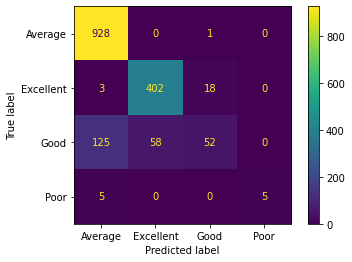

In [76]:
# plot confusion matrix for XGB model (replace x with rf to get matrix for random forest model)
plot_confusion_matrix(model_x, 
                      class_X_test, 
                      class_y_test,
                      values_format='.0f',
                      display_labels=['Average', 'Excellent', 'Good', 'Poor'])

In [77]:
# get precision, recall, and F1 scores for random forest model (replace rf with x to get scores for XGB model)
print(classification_report(class_y_test, model_rf.predict(class_X_test)))

class_y_test.value_counts()

                 precision    recall  f1-score   support

  Average Score       0.84      0.99      0.91       929
Excellent Score       0.90      0.92      0.91       423
     Good Score       0.56      0.14      0.23       235
     Poor Score       1.00      0.20      0.33        10

       accuracy                           0.84      1597
      macro avg       0.82      0.56      0.60      1597
   weighted avg       0.81      0.84      0.81      1597



Average Score      929
Excellent Score    423
Good Score         235
Poor Score          10
Name: TARGET_CLASSIFICATION, dtype: int64

Text(0.5, 1.0, 'Coefficients for Ridge Regression')

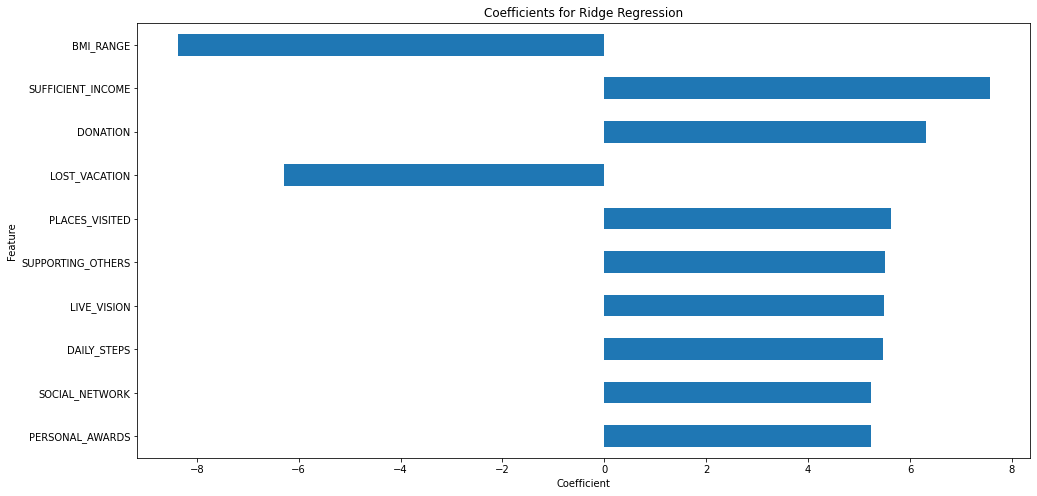

In [78]:
# See top features in ridge regression model
from matplotlib.pyplot import figure

coefficients = model_r.named_steps['ridge'].coef_
features = model_r.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh', figsize=(16,8))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression')

In [79]:
# get permutation importances for all models 

# Linear Regression
perm_imp_lr = permutation_importance(model_lr,
                                     regression_X_test,
                                     regression_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_lr.importances_mean,
        'imp_std' : perm_imp_lr.importances_std}

perm_imp_lr = pd.DataFrame(data, index=regression_X_test.columns)

# Ridge
perm_imp_r = permutation_importance(model_r,
                                     regression_X_test,
                                     regression_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_r.importances_mean,
        'imp_std' : perm_imp_r.importances_std}

perm_imp_r = pd.DataFrame(data, index=regression_X_test.columns)

# XGBoost
perm_imp_x = permutation_importance(model_x,
                                     class_X_test,
                                     class_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_x.importances_mean,
        'imp_std' : perm_imp_x.importances_std}

perm_imp_x = pd.DataFrame(data, index=class_X_test.columns)

# Random Forest 
perm_imp_rf = permutation_importance(model_rf,
                                     class_X_test,
                                     class_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_rf.importances_mean,
        'imp_std' : perm_imp_rf.importances_std}

perm_imp_x = pd.DataFrame(data, index=class_X_test.columns)



# Show Perm Imp for all three models 
print(perm_imp_lr, perm_imp_r, perm_imp_x, perm_imp_rf)

                   imp_mean   imp_std
FRUITS_VEGGIES     0.022686  0.000267
DAILY_STRESS       0.018409  0.000383
PLACES_VISITED     0.029790  0.000785
CORE_CIRCLE        0.022159  0.000520
SUPPORTING_OTHERS  0.028890  0.000409
SOCIAL_NETWORK     0.025415  0.000672
ACHIEVEMENT        0.021188  0.000314
DONATION           0.036207  0.000805
BMI_RANGE          0.064218  0.001608
TODO_COMPLETED     0.018446  0.000430
FLOW               0.015022  0.000260
DAILY_STEPS        0.028605  0.000889
LIVE_VISION        0.027991  0.001055
SLEEP_HOURS        0.005021  0.000049
LOST_VACATION      0.036319  0.001380
DAILY_SHOUTING     0.019776  0.000326
SUFFICIENT_INCOME  0.054396  0.001419
PERSONAL_AWARDS    0.026050  0.000532
TIME_FOR_PASSION   0.020267  0.000687
WEEKLY_MEDITATION  0.023501  0.000474
AGE                0.000000  0.000000
GENDER             0.000000  0.000000                        imp_mean       imp_std
FRUITS_VEGGIES     2.268738e-02  2.671836e-04
DAILY_STRESS       1.841030e-02  3

In [80]:
# confirm formatting
perm_imp_x

,imp_mean,imp_std
FRUITS_VEGGIES,0.015028,0.003042
DAILY_STRESS,0.007890,0.001092
PLACES_VISITED,0.030056,0.001726
CORE_CIRCLE,0.013901,0.003026
SUPPORTING_OTHERS,0.028303,0.002948
SOCIAL_NETWORK,0.008265,0.001652
ACHIEVEMENT,0.017408,0.004808
DONATION,0.012273,0.001883
BMI_RANGE,0.020413,0.003912
TODO_COMPLETED,0.021791,0.002035


(<Figure size 1080x1224 with 9 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f7d16f7e8d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7d02e16e90>})

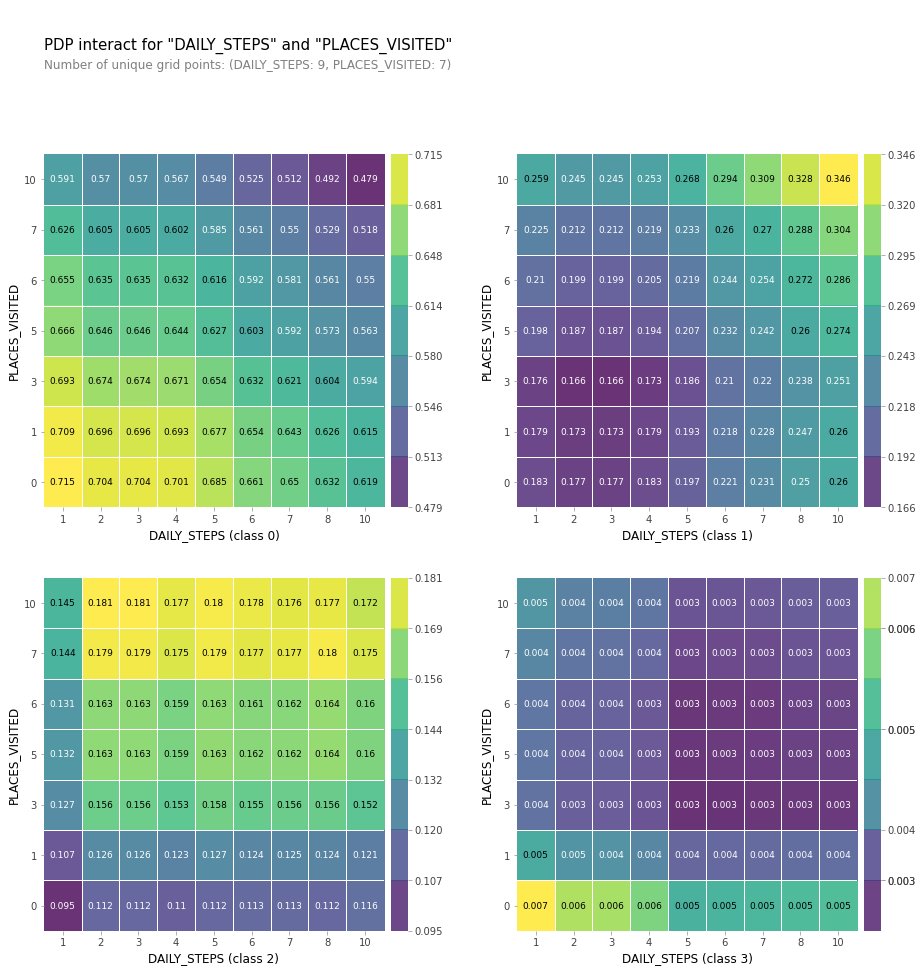

In [81]:
# Plot PDP for XGB model 
# toggle to random forest model by replacing x for rf
# toggle features depending on whether BMI and Income were dropped or not

features = ['DAILY_STEPS', 'PLACES_VISITED']


interact = pdp_interact(model_x,
                        dataset=class_X_test.dropna(),
                        model_features=class_X_test.columns,
                        features=features)
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7cffac01d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7cffab5c90>})

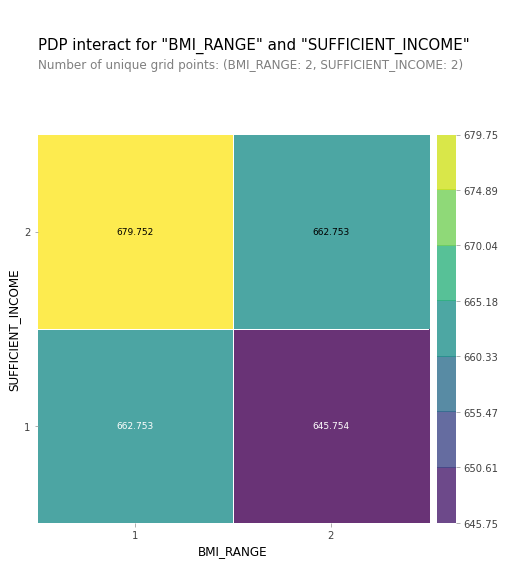

In [82]:
# Plot PDP for ridge model 
# toggle to linear regression model by replacing r for lr
# toggle features depending on whether BMI and Income were dropped or not

features = ['BMI_RANGE', 'SUFFICIENT_INCOME']


interact = pdp_interact(model_r,
                        dataset=regression_X_test.dropna(),
                        model_features=regression_X_test.columns,
                        features=features)
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

In [ ]:
# Shap plot - drop AGE column in wrangle to run for Ridge and Linear Regression Models 


model_gb = model_lr
model_gb.fit(X_train_r, y_train_r);


row = X_train_r.tail(1)

explainer = shap.Explainer(model_gb)
shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features=row
)